In [357]:
# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Finance related operations
from pandas_datareader import data

# Import this to silence a warning when converting data column of a dataframe on the fly
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Train-Test Splitting
from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. Load Data

We are loading the every csv file separately from the Data folder in the project directory. Once we have stored them in our Notebook we merge them together to form a larger dataframe containing all the information we have available.

In [358]:
df_2014 = pd.read_csv('Data/2014_Financial_Data.csv')
df_2014.rename(columns={df_2014.columns[0]:'Tickers'}, inplace=True)
df_2014 = pd.concat([pd.Series(df_2014['Tickers']).apply(lambda x: f'{x}-2014'), df_2014.iloc[:,1:]], axis=1)
df_2014.set_index('Tickers')

df_2015 = pd.read_csv('Data/2015_Financial_Data.csv')
df_2015.rename(columns={df_2015.columns[0]:'Tickers'}, inplace=True)
df_2015 = pd.concat([pd.Series(df_2015['Tickers']).apply(lambda x: f'{x}-2015'), df_2015.iloc[:,1:]], axis=1)
df_2015.set_index('Tickers')

df_2016 = pd.read_csv('Data/2016_Financial_Data.csv')
df_2016.rename(columns={df_2016.columns[0]:'Tickers'}, inplace=True)
df_2016 = pd.concat([pd.Series(df_2016['Tickers']).apply(lambda x: f'{x}-2016'), df_2016.iloc[:,1:]], axis=1)
df_2016.set_index('Tickers')

df_2017 = pd.read_csv('Data/2017_Financial_Data.csv')
df_2017.rename(columns={df_2017.columns[0]:'Tickers'}, inplace=True)
df_2017 = pd.concat([pd.Series(df_2017['Tickers']).apply(lambda x: f'{x}-2017'), df_2017.iloc[:,1:]], axis=1)
df_2017.set_index('Tickers')

df_2018 = pd.read_csv('Data/2018_Financial_Data.csv')
df_2018.rename(columns={df_2018.columns[0]:'Tickers'}, inplace=True)
df_2018 = pd.concat([pd.Series(df_2018['Tickers']).apply(lambda x: f'{x}-2018'), df_2018.iloc[:,1:]], axis=1)
df_2018.set_index('Tickers')


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
Tickers,,,,,,,,,,,,,,,,,,,,,
CMCSA-2018,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,...,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1
KMI-2018,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,...,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1
INTC-2018,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,...,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1
MU-2018,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.430300e+10,...,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1
GE-2018,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,-2.177200e+10,...,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YRIV-2018,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,3.755251e+06,3.755251e+06,-3.755251e+06,1.105849e+07,-1.482451e+07,...,0.0000,0.0000,-0.0508,-0.1409,-0.0152,0.0000,-0.2602,Real Estate,-90.962099,0
YTEN-2018,5.560000e+05,-0.4110,0.000000e+00,5.560000e+05,4.759000e+06,5.071000e+06,9.830000e+06,-9.274000e+06,0.000000e+00,-9.170000e+06,...,0.3445,0.0000,-0.2323,-0.8602,0.0000,0.0352,-0.0993,Basic Materials,-77.922077,0
ZKIN-2018,5.488438e+07,0.2210,3.659379e+07,1.829059e+07,1.652633e+06,7.020320e+06,8.672953e+06,9.617636e+06,1.239170e+06,8.416324e+06,...,0.1605,0.7706,0.2489,0.4074,-0.0968,0.2415,0.8987,Basic Materials,-17.834400,0


Now we add new YEAR column to each of the dataframes to later being able to group the rows by their year. We add them to an array, so we can iterate over them.

In [359]:
df_2014['year'] = '2014'
df_2015['year'] = '2015'
df_2016['year'] = '2016'
df_2017['year'] = '2017'
df_2018['year'] = '2018'

dataframes = [df_2014, df_2015, df_2016, df_2017, df_2018]

# 2. Merging of datasets

In [360]:
for df in dataframes:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Columns: 226 entries, Tickers to year
dtypes: float64(222), int64(1), object(3)
memory usage: 6.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4120 entries, 0 to 4119
Columns: 226 entries, Tickers to year
dtypes: float64(222), int64(1), object(3)
memory usage: 7.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Columns: 226 entries, Tickers to year
dtypes: float64(222), int64(1), object(3)
memory usage: 8.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Columns: 226 entries, Tickers to year
dtypes: float64(222), int64(1), object(3)
memory usage: 8.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Columns: 226 entries, Tickers to year
dtypes: float64(222), int64(1), object(3)
memory usage: 7.6+ MB
None


We can see that the datasets are quite similar. The only thing that varies between them is the number of rows. As we want to append all the datasets to form a bigger dataset we expect 3808 + 4120 + 4797 + 4960 + 4392 = 22'077 rows in the generated dataset.

Looking at the column data types we have:
- 222 numeric (financial indicators)
- 1 integer (the **class** column)
- 2 objects (**Sector and Price Change** column)

In order to be able to append all the dataframes together we have to make sure all the columns have the same naming. It looks like the only column that is named differently from all the others across the datasets is the price change column. We are renaming it to 'PRICE CHANGE [%]'.


In [361]:
year = 2015
for df in dataframes:
    df.rename(columns = {f'{year} PRICE VAR [%]': 'PRICE CHANGE [%]'}, inplace=True)
    year += 1

To check our assumption and see if now all the columns really are the same we use the numpy array_equal function.

In [362]:
columns_2014 = df_2014.columns.values.tolist()
columns_2015 = df_2015.columns.values.tolist()
columns_2016 = df_2016.columns.values.tolist()
columns_2017 = df_2017.columns.values.tolist()
columns_2018 = df_2018.columns.values.tolist()

print(f'Columns in df 2014 and 2015 are equal: {np.array_equal(columns_2014, columns_2015)}')
print(f'Columns in df 2015 and 2016 are equal: {np.array_equal(columns_2015, columns_2016)}')
print(f'Columns in df 2016 and 2017 are equal: {np.array_equal(columns_2016, columns_2017)}')
print(f'Columns in df 2017 and 2018 are equal: {np.array_equal(columns_2017, columns_2018)}')

Columns in df 2014 and 2015 are equal: True
Columns in df 2015 and 2016 are equal: True
Columns in df 2016 and 2017 are equal: True
Columns in df 2017 and 2018 are equal: True


As we see that all computations output TRUE. By reflexivity we know that the columns of all the datasets now have the same values. Now we can start appending them to form the mega-dataset we want to start working with.

In [363]:
df = pd.concat(dataframes)

As expected we get a new dataframe with 22'077 entries and the common number of columns (225) of the individual datasets.

# 3. Start cleaning
Now that we have some information at one place we can start cleaning the dataset.

## 3.1 Price Change outliers
As Price change is probably our most important feature we want to prepare that one first. This section is strongly inspired by an analysis done by Nicolas Carbone and can be found [HERE](https://www.kaggle.com/cnic92/explore-and-clean-financial-indicators-dataset)
We are looking for major peaks/valleys, which indicate stocks that increased/decreased in value by an incredible amount with respect to the overall sector.

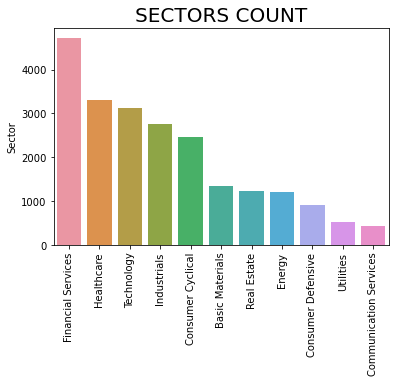

In [364]:
sectors = df['Sector'].unique().tolist()

df_sector = df['Sector'].value_counts()
sns.barplot(x=np.arange(len(df_sector)), y=df_sector)
plt.xticks(np.arange(len(df_sector)), df_sector.index.values.tolist(), rotation=90)
plt.title('SECTORS COUNT', fontsize=20)
plt.show()

As we see our dataset is unbalanced in regards to the sector count. This can lead to overfitting, but we will leave the data as is as it represents the true distribution of sectors in reality. Now let's take a look at a graphical representation of all the returns within a sector in the year 2019.

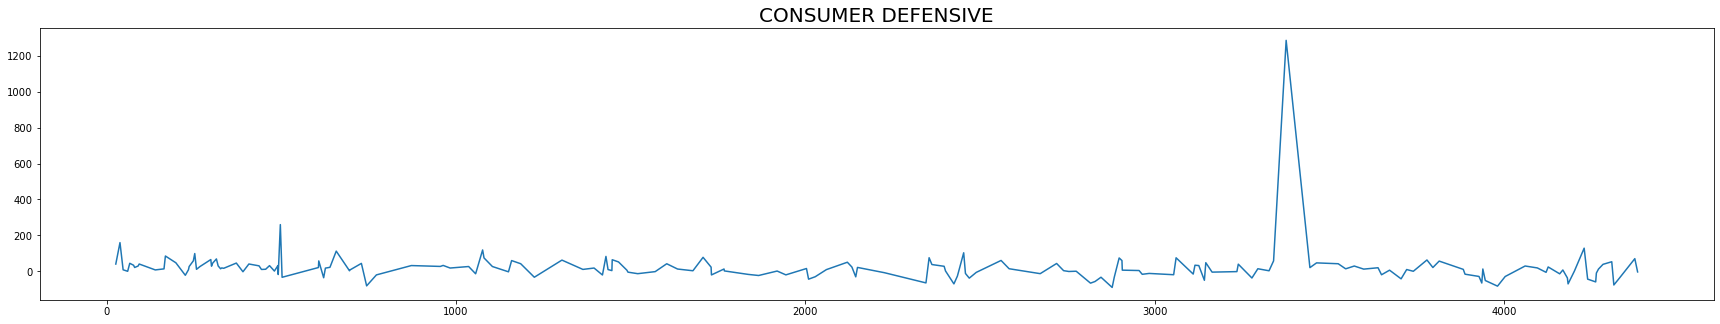

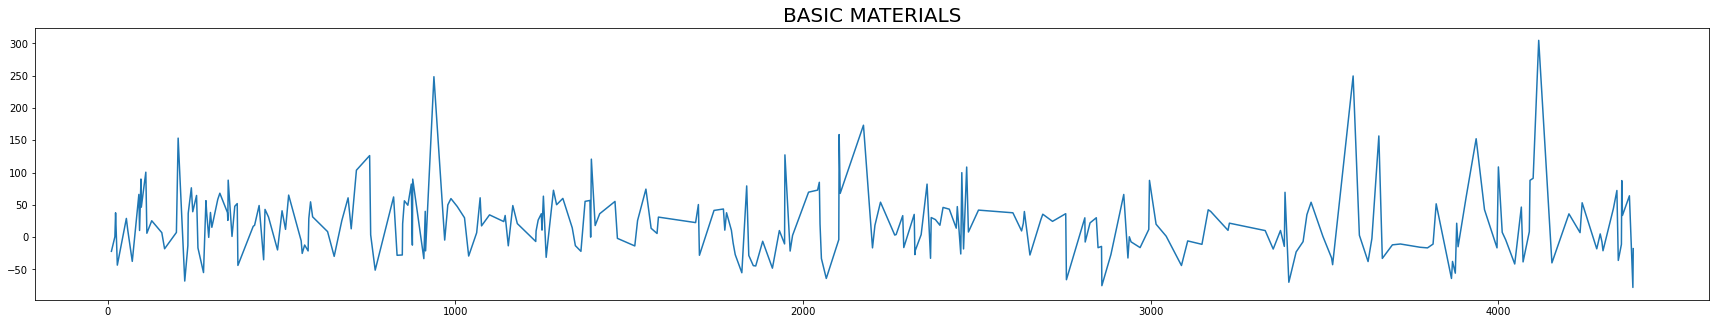

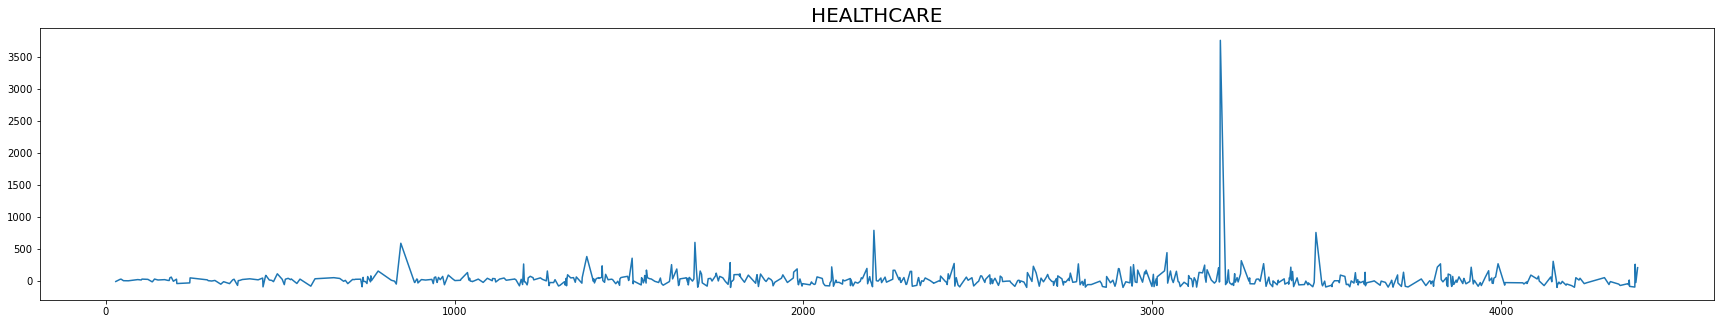

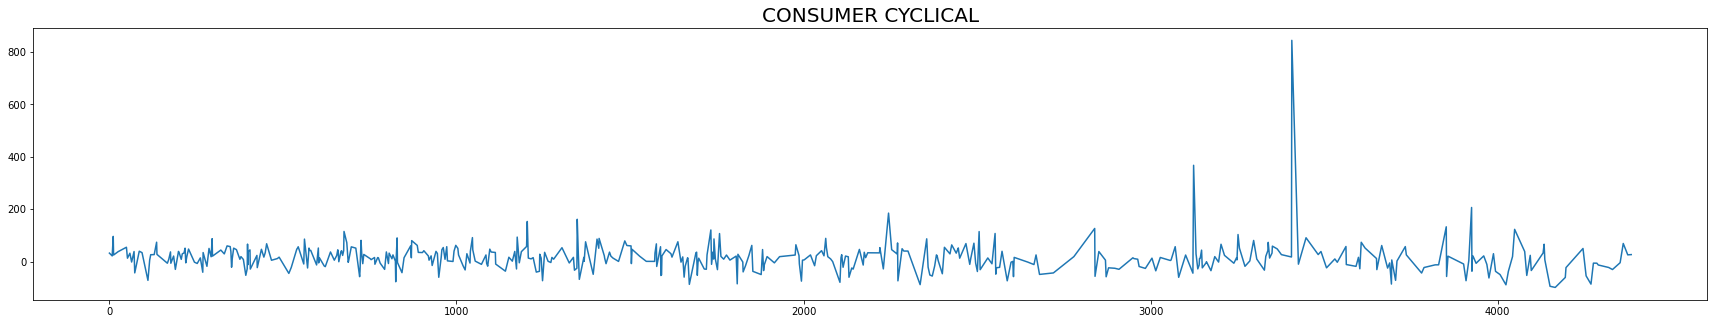

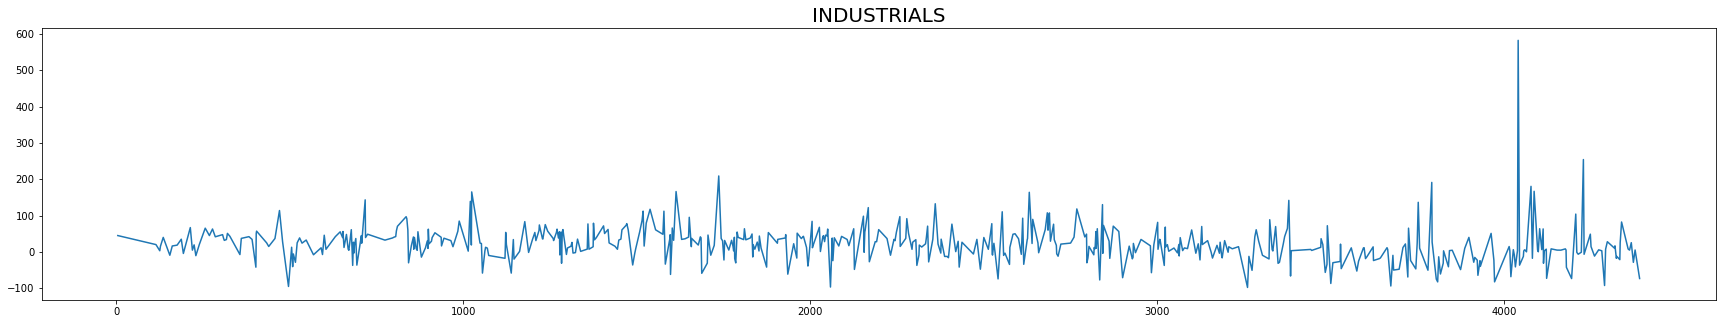

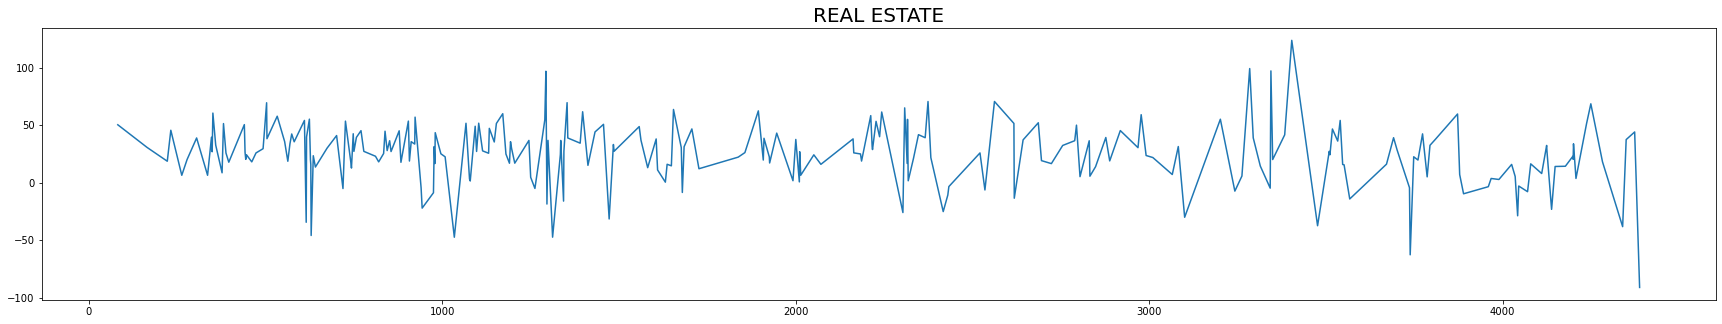

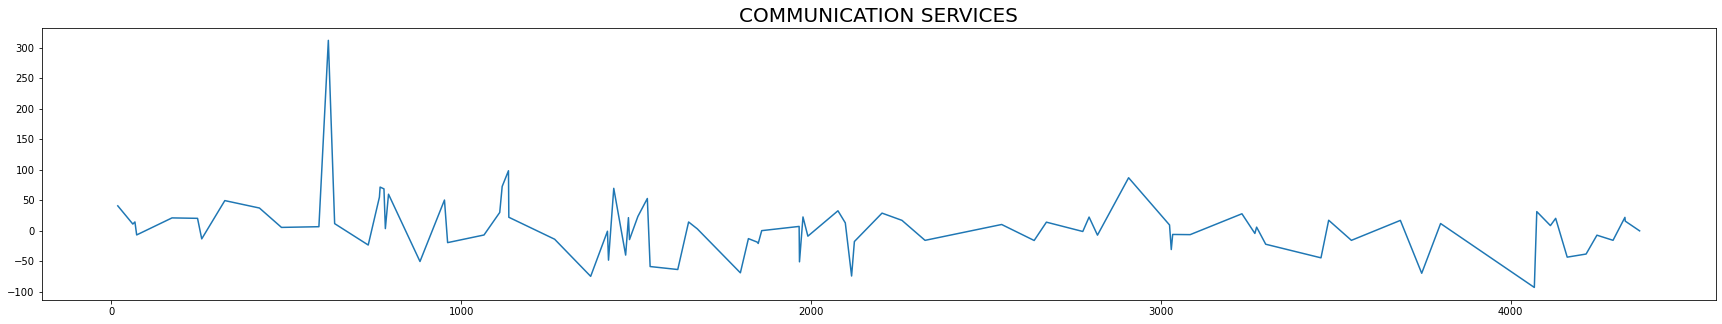

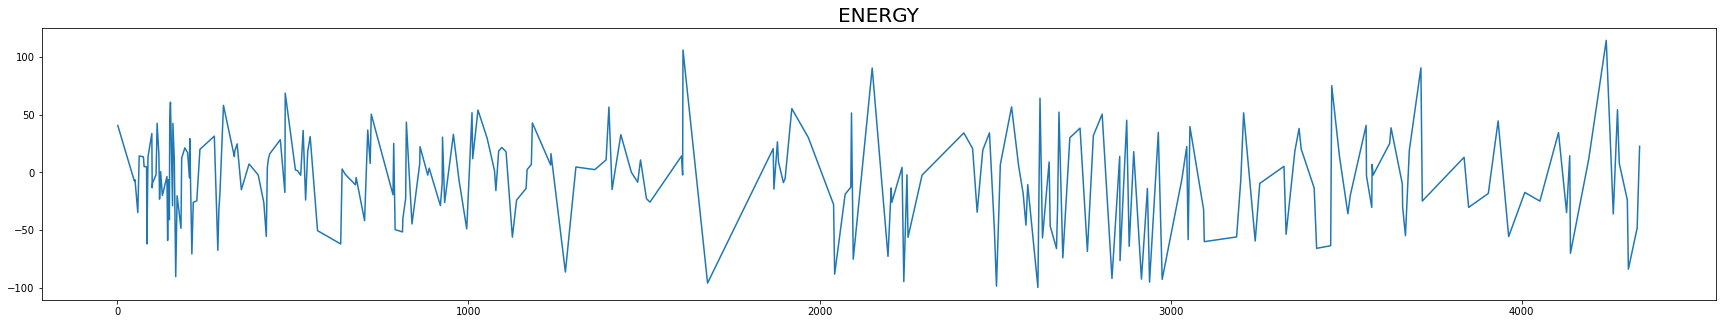

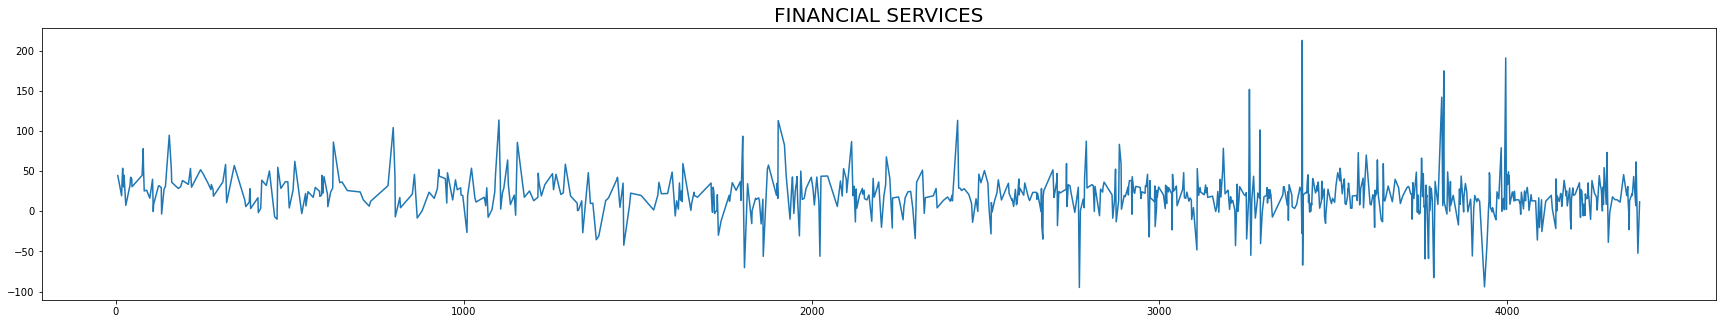

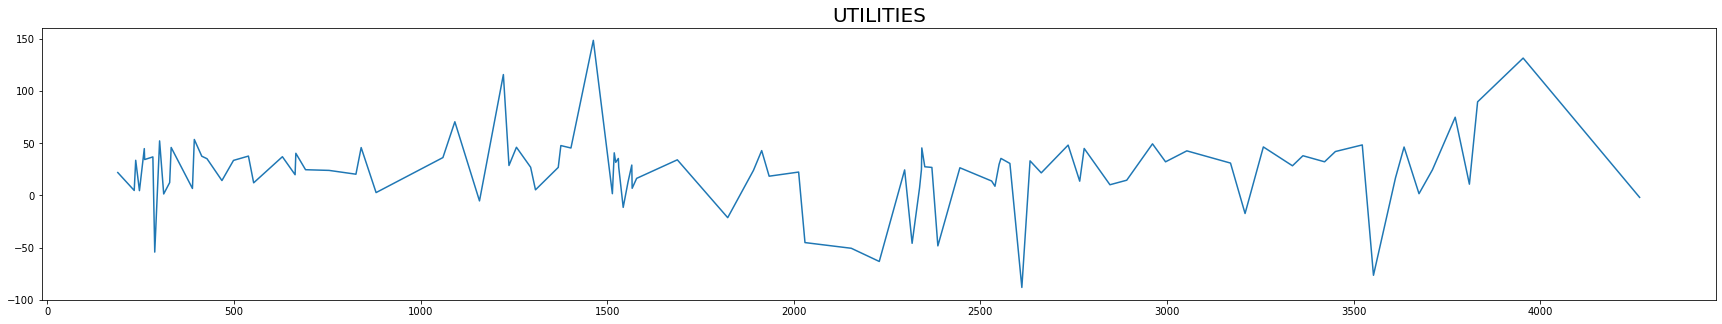

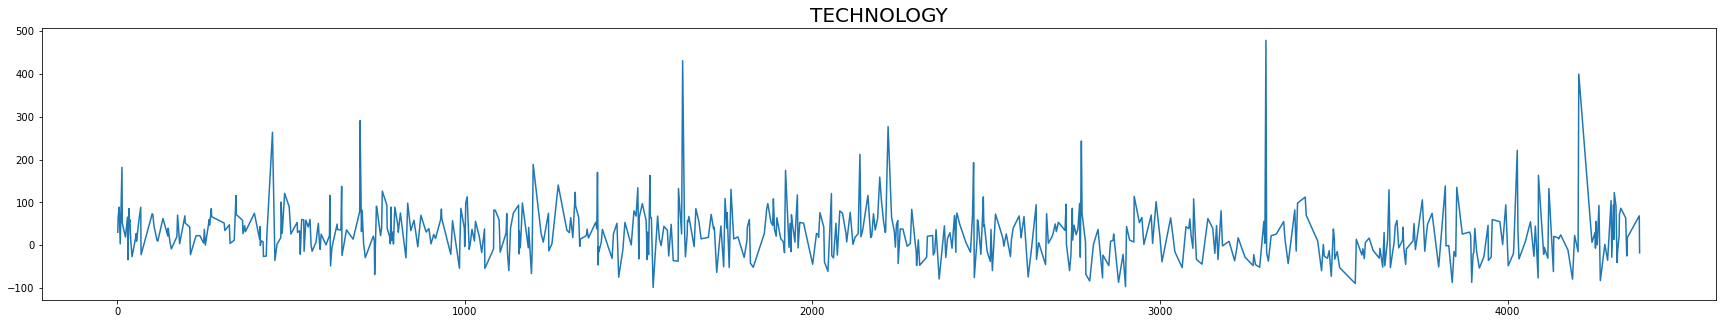

In [365]:
# Extract the columns we need in this step from the dataframe
df_ = df_2018.loc[:, ['Sector', 'PRICE CHANGE [%]']]

# Get list of sectors
sector_list = df_['Sector'].unique()

# Plot the percent price variation for each sector
for sector in sectors:

    temp = df_[df_['Sector'] == sector]

    plt.figure(figsize=(30,5))
    plt.plot(temp['PRICE CHANGE [%]'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

As we see there is quite a number of peaks. We now want to dig a little deeper into that and examine wether those price changes could have been organic or inorganic growth. [Nicolas Carbone](https://www.kaggle.com/cnic92/explore-and-clean-financial-indicators-dataset) suggests to determine a threshhold, find all stocks that have performed better than the threshhold and get some financial data from Yahoo Finance for these specific stocks. More precisely we will compare the *Adjusted Daily Close Price* to the *Volume* and decide on that basis if it was organic or inorganic growth. We will do exactly that for every stock that had a performance greater that 500% in any year of our dataset.
Since the code for determining that in any year is mostly the same but only changes in some specific variables I will create a function that we will be able to reuse throughout the code.

In [366]:
def find_inorganic_stocks(df_, year, gain):
    inorganic_stocks = df_[df_['PRICE CHANGE [%]'] >= gain]
    top_gainers = inorganic_stocks[['Tickers','PRICE CHANGE [%]']].sort_values(by='PRICE CHANGE [%]', ascending=False)
    print(f'{len(inorganic_stocks)} STOCKS with more than {gain}% gain.')
    print()

    # Set
    date_start = f'01-01-{year}'
    date_end = f'12-31-{year}'
    #print(top_gainers)
    tickers = top_gainers['Tickers'].values.tolist()

    temp=[]

    for ticker in tickers:
        split_ticker = ticker.split('-')
        try:
            # Get daily prices for that stock from Yahoo finance
            daily_price = data.DataReader(split_ticker[0], 'yahoo', date_start, date_end)

            # Plot prices with volume
            fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

            ax0.plot(daily_price['Adj Close'])
            ax0.set_title(ticker, fontsize=18)
            ax0.set_ylabel('Daily Adj Close $', fontsize=14)
            ax1.plot(daily_price['Volume'])
            ax1.set_ylabel('Volume', fontsize=14)
            ax1.yaxis.set_major_formatter(
                    matplotlib.ticker.StrMethodFormatter('{x:.0E}'))

            fig.align_ylabels(ax1)
            fig.tight_layout()
            plt.show()

        except Exception as e:
            print(e)

    return tickers


### 3.1.1 Price Changes >500% in 2014

22 STOCKS with more than 500% gain.



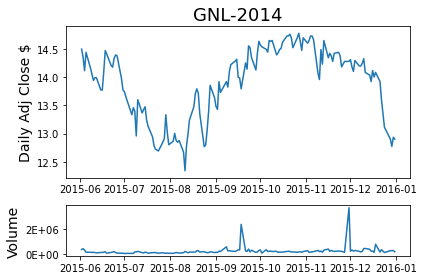

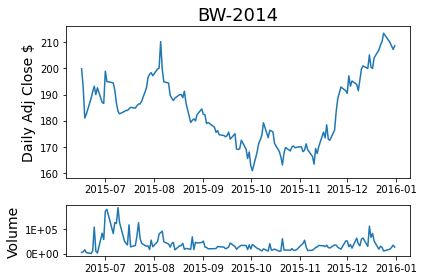

No data fetched for symbol NK using YahooDailyReader
No data fetched for symbol PUB using YahooDailyReader


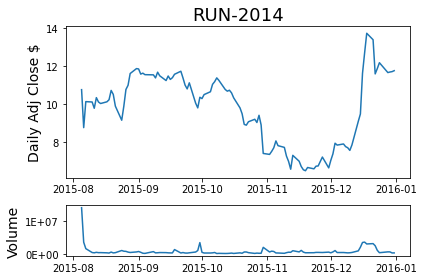

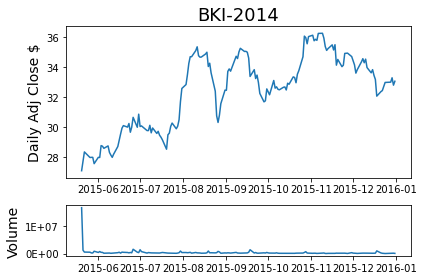

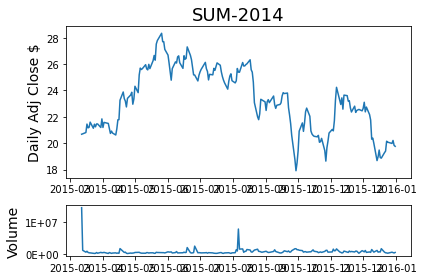

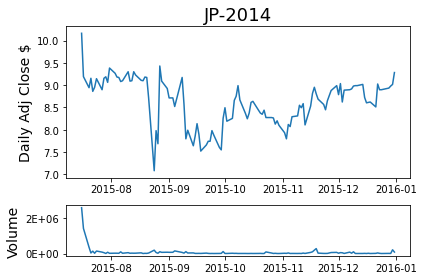

No data fetched for symbol JAX using YahooDailyReader


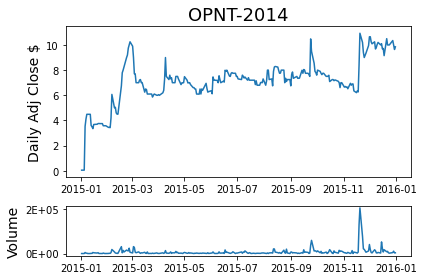

No data fetched for symbol AMRH using YahooDailyReader


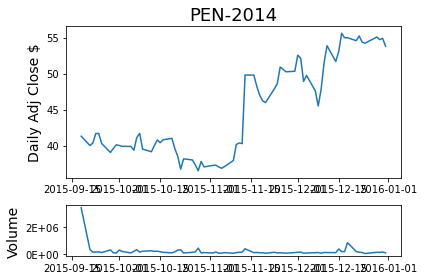

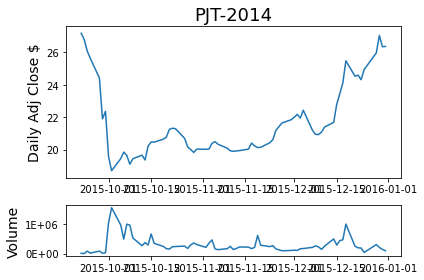

No data fetched for symbol FSB using YahooDailyReader


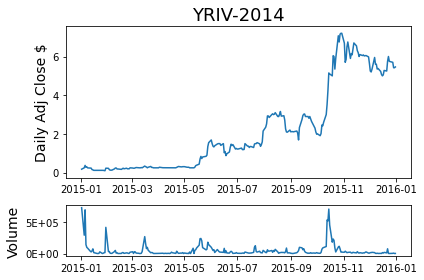

No data fetched for symbol LBCC using YahooDailyReader


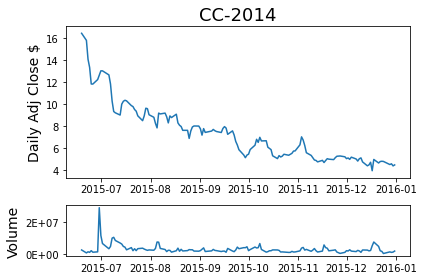

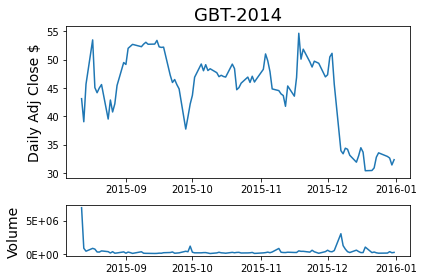

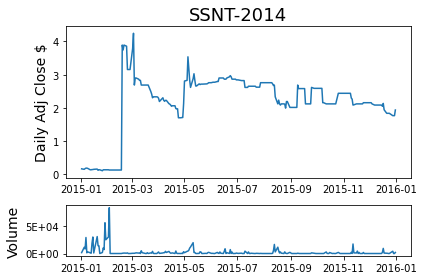

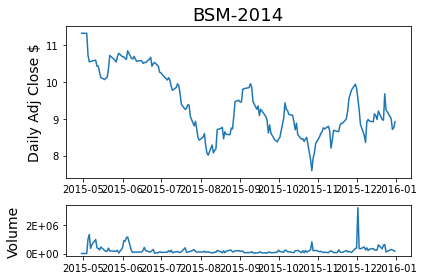

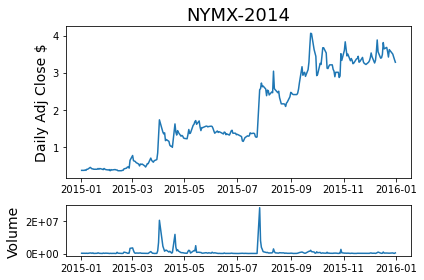

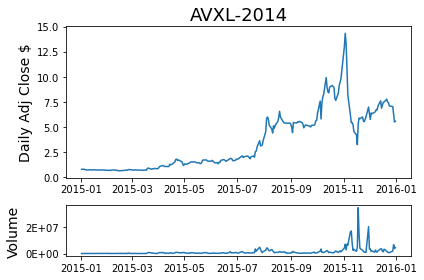

In [367]:
high_gainers_2014 = find_inorganic_stocks(df_2014, 2015, 500)

Looking at these plots we have a lot of flat trading volume, very massive spikes and data that is not available for the entire year. For these cases we assume that these stocks did not grow organically. So we end up only taking *NYMX* and *AVXL* as organic growth. Therefore we exclude them from the high_gainers_2014 and drop those stocks then from the 2014 dataset.

In [368]:
high_gainers_2014.remove('NYMX-2014')
high_gainers_2014.remove('AVXL-2014')
df_2014=df_2014.set_index('Tickers')
df_2014.drop(high_gainers_2014, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2015

10 STOCKS with more than 500% gain.

No data fetched for symbol ARA using YahooDailyReader
No data fetched for symbol LN using YahooDailyReader


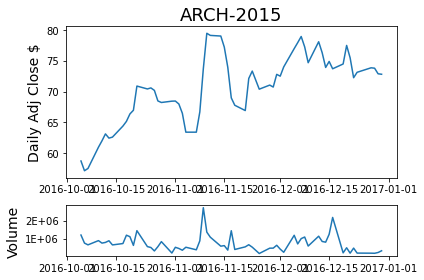

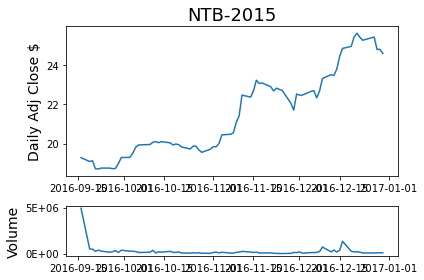

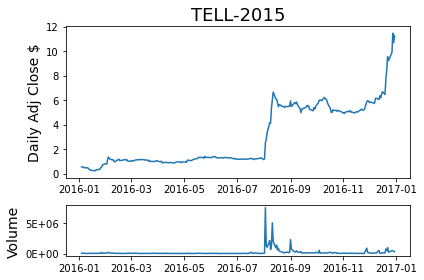

No data fetched for symbol WINS using YahooDailyReader


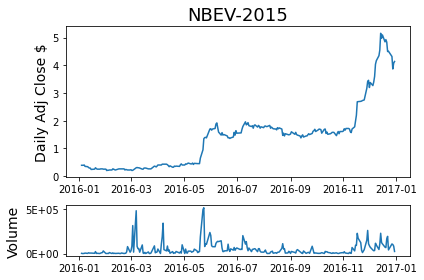

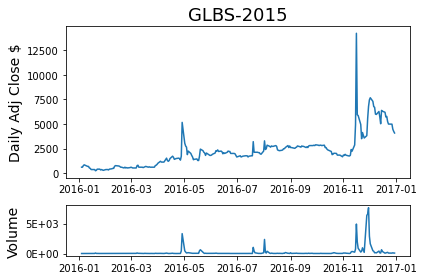

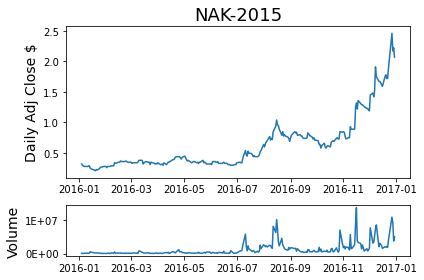

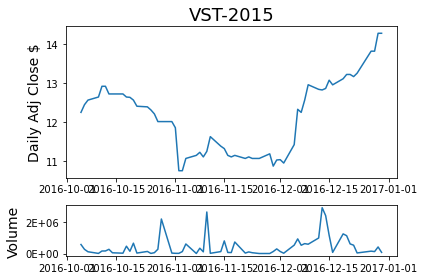

['ARA-2015', 'LN-2015', 'ARCH-2015', 'NTB-2015', 'TELL-2015', 'WINS-2015', 'NBEV-2015', 'GLBS-2015', 'NAK-2015', 'VST-2015']


In [369]:
high_gainers_2015 = find_inorganic_stocks(df_2015, 2016, 500)
print(high_gainers_2015)

In [370]:
# we are keeping  NAK and NBEV
high_gainers_2015.remove('NAK-2015')
high_gainers_2015.remove('NBEV-2015')
df_2015=df_2015.set_index('Tickers')
df_2015.drop(high_gainers_2015, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2016

19 STOCKS with more than 500% gain.



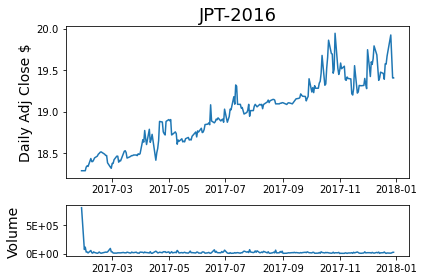

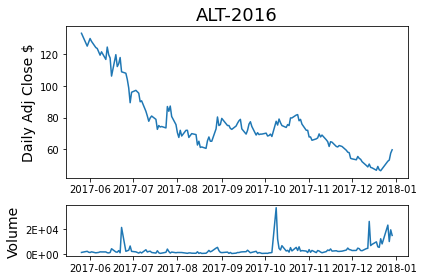

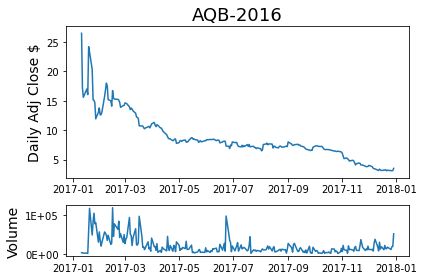

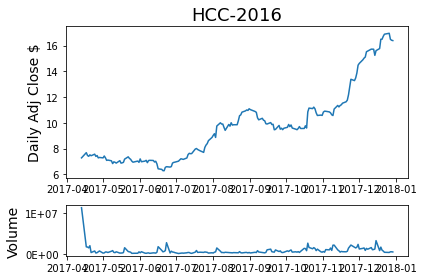

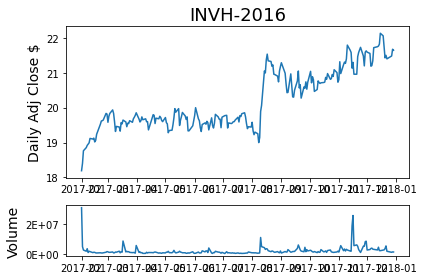

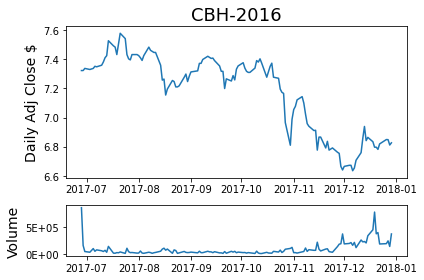

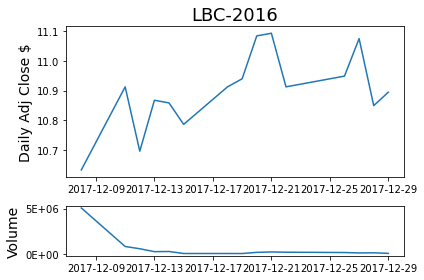

No data fetched for symbol JAG using YahooDailyReader


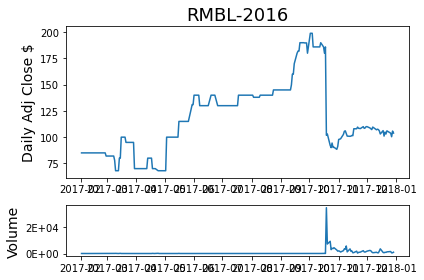

No data fetched for symbol AKCA using YahooDailyReader


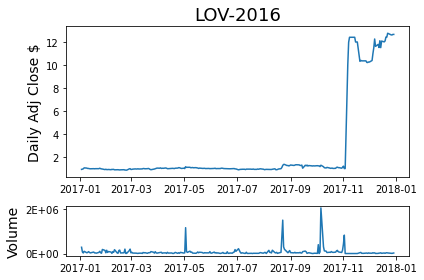

No data fetched for symbol FTNW using YahooDailyReader


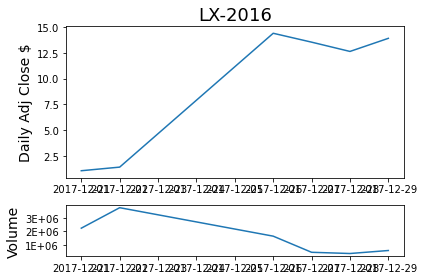

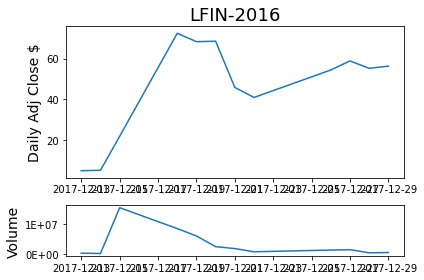

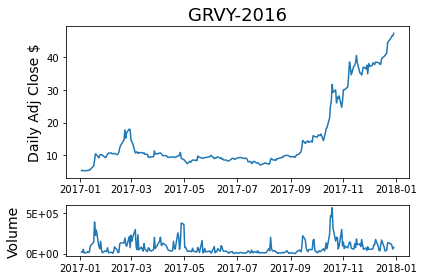

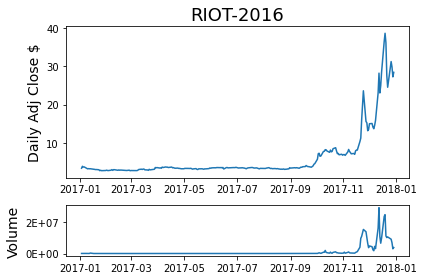

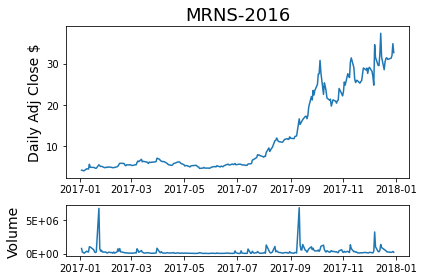

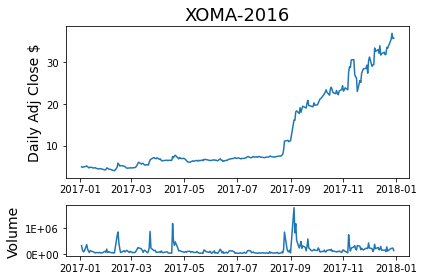

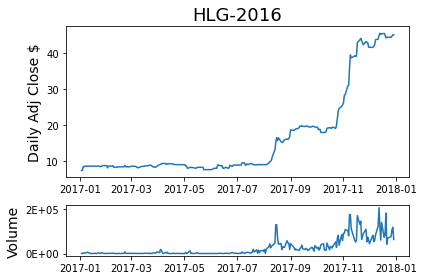

In [371]:
high_gainers_2016 = find_inorganic_stocks(df_2016, 2017, 500)

In [372]:
# we are keeping  HlG and GRVY
high_gainers_2016.remove('HLG-2016')
high_gainers_2016.remove('GRVY-2016')
df_2016=df_2016.set_index('Tickers')
df_2016.drop(high_gainers_2016, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2017

5 STOCKS with more than 500% gain.

No data fetched for symbol HMI using YahooDailyReader
No data fetched for symbol SIGM using YahooDailyReader


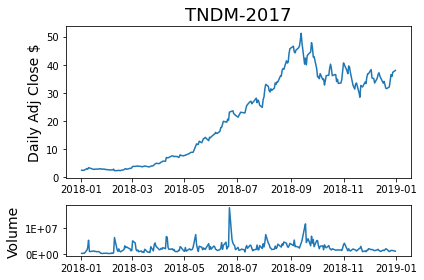

No data fetched for symbol NIHD using YahooDailyReader


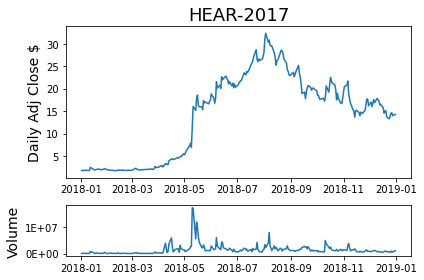

In [373]:
high_gainers_2017 = find_inorganic_stocks(df_2017, 2018, 500)

In [374]:
# we are keeping  HEAR and TNDM
high_gainers_2017.remove('HEAR-2017')
high_gainers_2017.remove('TNDM-2017')
df_2017=df_2017.set_index('Tickers')
df_2017.drop(high_gainers_2017, axis=0, inplace=True)

### 3.1.2 Price Changes >500% in 2018

8 STOCKS with more than 500% gain.



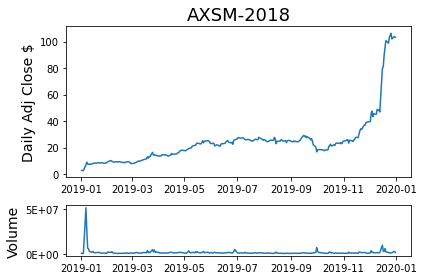

No data fetched for symbol ANFI using YahooDailyReader
No data fetched for symbol SSI using YahooDailyReader


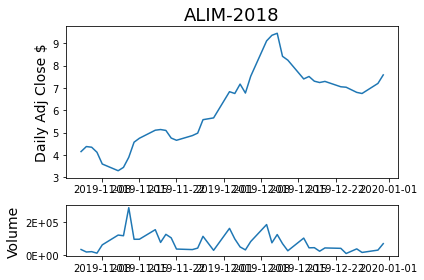

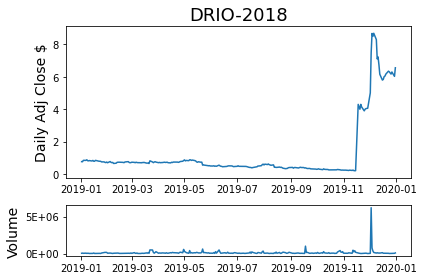

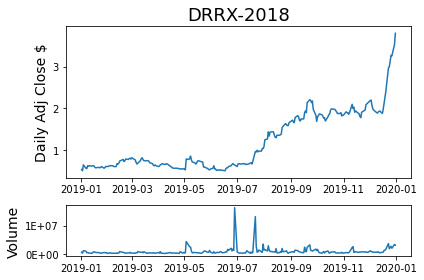

No data fetched for symbol ARQL using YahooDailyReader
No data fetched for symbol HEBT using YahooDailyReader


In [375]:
high_gainers_2018 = find_inorganic_stocks(df_2018, 2019, 500)

In [376]:
# we are keeping  ALIM
high_gainers_2018.remove('ALIM-2018')
df_2018=df_2018.set_index('Tickers')
df_2018.drop(high_gainers_2018, axis=0, inplace=True)

# 4. Missing values and 0-values

Our dataset contains lots of 0 and missing values. In this chapter we will discuss our approach to remove/replace them. First of all we create a larger dataset by appending all the separate datasets onto each other. Then we will take a closer look at the missing and 0 values and decide how many are allowed to miss in a column in order to keep the column. After that we will get rid of those columns and replace the missing values that are left with an appropriate dummy variable.

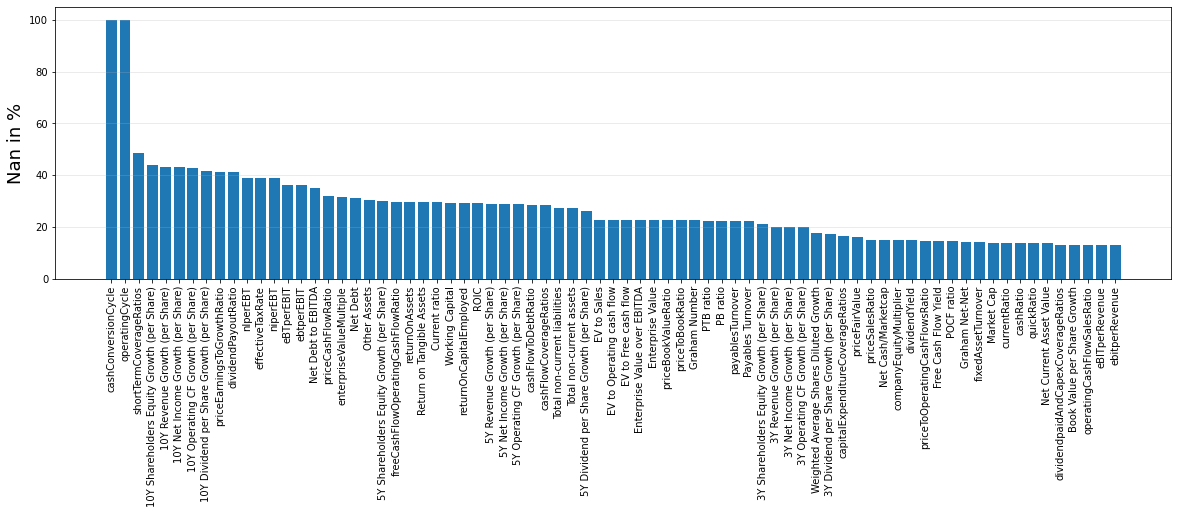

In [377]:
# Find count and percent of nan-values, zero-values
percent_nan = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(20,5))
plt.bar(np.arange(75), percent_nan.iloc[:75].values.tolist())
plt.xticks(np.arange(75), percent_nan.iloc[:75].index.values.tolist(), rotation='90')
plt.ylabel('Nan in %', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

#drop all of the columns that have more than 20% Nan values
df.drop(percent_nan[percent_nan.values > 20].index.tolist(),axis='columns', inplace=True)

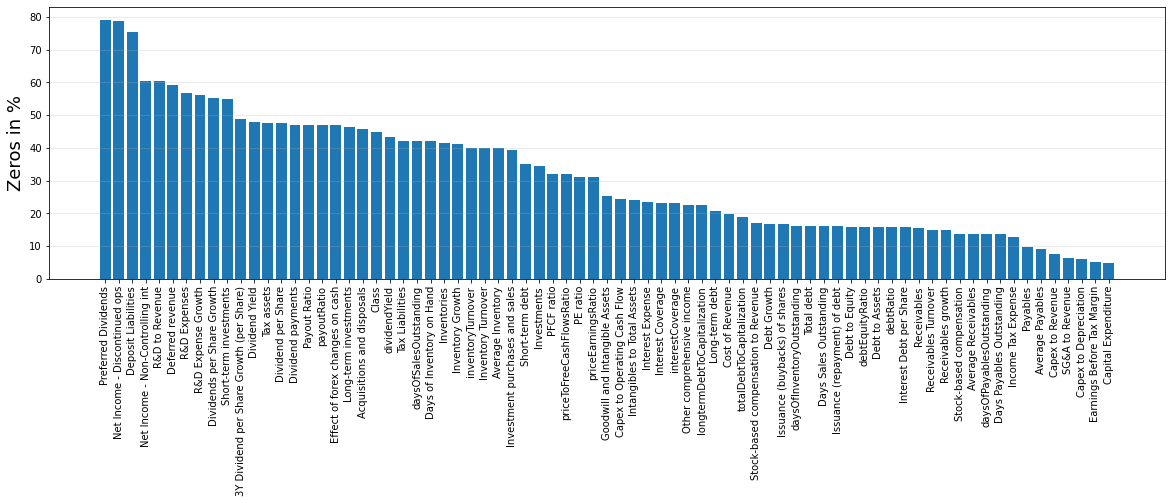

In [378]:
percent_zero = (df.isin([0]).sum()/df.shape[0]*100).sort_values(ascending=False)

plt.figure(figsize=(20,5))
plt.bar(np.arange(75), percent_zero.iloc[:75].values.tolist())
plt.xticks(np.arange(75), percent_zero.iloc[:75].index.values.tolist(), rotation='90')
plt.ylabel('Zeros in %', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

df.drop(percent_zero[percent_zero.values > 20].index.tolist(),axis='columns', inplace=True)

We have quite a lot unwanted variables in some columns. Let's drop all the columns that have more than 20 percent of unwelcomed values.

In [379]:
print(f'NUMBER OF FEATURES: {df.shape[1]}')

NUMBER OF FEATURES: 128


# 5. Outliers/Extreme values

Since outliers pollute our dataset we will go ahead dropping top and bottom 5%

In [380]:
top_quantiles = df.quantile(0.95)
outliers_top = (df > top_quantiles)

low_quantiles = df.quantile(0.05)
outliers_low = (df < low_quantiles)

df = df.mask(outliers_top, top_quantiles, axis=1)
df = df.mask(outliers_low, low_quantiles, axis=1)

/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_11180/2162141620.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_top = (df > top_quantiles)
/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_11180/2162141620.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_low = (df < low_quantiles)


# 6. Fill Unappropriate values reasonably

We will be filling the missing values with the sector mean of a given year. But before thatwe will split our dataset into a train and a test set to prevent information from the training set to leak into the test set.

In [381]:
df.replace(0, np.nan, inplace=True)
# Replace nan-values with mean value of column, considering each sector individually.
df.info()

sectors = df
# df_no_sector= df.groupby(['Sector', 'year']).transform(lambda x: x.fillna(x.mean()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 0 to 4391
Columns: 128 entries, Tickers to year
dtypes: float64(125), object(3)
memory usage: 21.7+ MB


In [382]:
#percent_nan = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
#percent_zero = (df.isin([0]).sum()/df.shape[0]*100).sort_values(ascending=False)

In [383]:
#percent_zero

In [439]:
sp500 = pd.read_csv('Data/sp500.csv')
sp500 = sp500[-9:-3]
sp500['year'] = sp500['date'].apply(lambda x: x.split('-')[0])
#sp500 = sp500[sp500.columns[-2:]]
sp500.set_index('date')

,value,year
date,,
2014-12-31,11.39,2014
2015-12-31,-0.73,2015
2016-12-30,9.54,2016
2017-12-29,19.42,2017
2018-12-31,-6.24,2018
2019-12-31,28.88,2019


In [440]:
sp_df = pd.merge(left=df,right=sp500, left_on='year', right_on='year').set_index('Tickers')
sp_df.rename(columns={sp_df.columns[-1]: 'sp500-return'}, inplace=True)
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22077 entries, PG-2014 to ZYME-2018
Columns: 129 entries, Revenue to sp500-return
dtypes: float64(126), object(3)
memory usage: 21.9+ MB


In order to make the train/test split in the next step we must define the response column, we name it 'Investment Advice', first:
- if 'PRICE CHANGE [%]' - 'sp500-return' > 2.5 => 1 [BUY]
- if 'PRICE CHANGE [%]' - 'sp500-return' < 2.5  and 'PRICE CHANGE [%] - 'sp500-return' > -2.5 => 0 [HOLD]
- if 'PRICE CHANGE [%]' - 'sp500-return' < -2.5 => -1 [SELL]

In [442]:
def create_response(row):
    diff = row[0] - row[1]
    if diff > 2.5:
        return 1
    elif diff < -2.5:
        return -1

    return 0

In [444]:
response = sp_df[['PRICE CHANGE [%]', 'sp500-return']]
response['Investment Advice'] = response.apply(create_response, axis=1)
response = response['Investment Advice']
response

/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_11180/907635918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response['Investment Advice'] = response.apply(create_response, axis=1)


Tickers
PG-2014     -1
VIPS-2014   -1
KR-2014      1
RAD-2014    -1
GIS-2014     0
            ..
YRIV-2018   -1
YTEN-2018   -1
ZKIN-2018   -1
ZOM-2018    -1
ZYME-2018    1
Name: Investment Advice, Length: 22077, dtype: int64

In [469]:
x_train, x_test, y_train, y_test = train_test_split(sp_df,response,test_size=0.1, random_state=21)

Now that we have a train and a test set we will replace all missing values with a reasonable variable. For now we have decided to go with the sector mean.

In [470]:
x_train.info()
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19869 entries, RJF-2015 to VZ-2017
Columns: 129 entries, Revenue to sp500-return
dtypes: float64(126), object(3)
memory usage: 19.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 2208 entries, GMRE-2018 to IMMP-2016
Columns: 129 entries, Revenue to sp500-return
dtypes: float64(126), object(3)
memory usage: 2.2+ MB


In [471]:
# store Sectors df since we will need it later but lose it during calculation of the mean
sectors_df = x_train['Sector']
x_train_ = x_train.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))
x_train = pd.concat([x_train_, sectors_df], axis=1)
x_train

/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_11180/1324228833.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  x_train_ = x_train.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Income Tax Expense,Net Income,...,Free Cash Flow growth,Receivables growth,Asset Growth,Book Value per Share Growth,Debt Growth,SG&A Expenses Growth,PRICE CHANGE [%],year,sp500-return,Sector
Tickers,,,,,,,,,,,,,,,,,,,,,
RJF-2015,5.203606e+09,0.07040,1.023170e+08,5.101289e+09,3.573876e+09,4.286677e+09,8.146120e+08,7.981740e+08,2.960340e+08,5.021400e+08,...,0.842900,0.021600,0.134700,0.071900,0.030500,0.06390,24.815454,2015,-0.73,Financial Services
BBBY-2014,1.150396e+10,0.05400,6.938381e+09,4.565582e+09,2.950995e+09,2.950995e+09,1.614587e+09,1.613447e+09,5.911570e+08,1.022290e+09,...,0.205200,0.115615,0.012100,0.029800,0.133462,0.07290,-37.117168,2014,11.39,Consumer Cyclical
EIGI-2016,1.111142e+09,0.49890,5.839910e+08,5.271510e+08,4.466060e+08,5.664910e+08,-3.934000e+07,-1.410360e+08,-3.031380e+07,-7.283100e+07,...,-0.193700,0.087000,0.529100,-0.318700,0.803900,0.78378,7.692300,2016,9.54,Technology
MFC-2018,2.040475e+10,-0.31904,1.165087e+10,7.850082e+09,3.573876e+09,5.367974e+09,2.723871e+09,2.382800e+09,4.681481e+08,1.914130e+09,...,0.017000,0.124500,-0.030200,0.053400,-0.065100,0.03740,47.832096,2018,-6.24,Financial Services
DISCA-2018,1.055300e+10,0.53540,3.935000e+09,6.618000e+09,2.620000e+09,4.768000e+09,1.850000e+09,9.350000e+08,3.410000e+08,5.940000e+08,...,0.625800,0.425500,0.443100,0.402700,0.135800,0.48190,26.751846,2018,-6.24,Consumer Cyclical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC-2017,2.691500e+07,-0.13810,7.130000e+05,2.620200e+07,3.652300e+07,4.658800e+07,-2.038600e+07,6.417000e+06,-2.420000e+06,8.837000e+06,...,-3.303310,1.237935,0.057000,0.098100,-0.426000,0.17940,3.719716,2017,19.42,Financial Services
BDXA-2016,1.248300e+10,0.19238,6.492000e+09,5.991000e+09,3.005000e+09,4.561000e+09,1.430000e+09,1.074000e+09,9.700000e+07,9.760000e+08,...,-0.205443,0.210516,0.259885,0.083106,0.114911,0.23633,13.835859,2016,9.54,Healthcare
CUZ-2015,2.043690e+08,0.15100,8.254500e+07,1.218240e+08,2.034800e+07,9.345300e+07,2.837100e+07,1.255180e+08,1.127297e+07,1.255180e+08,...,1.600900,0.137100,-0.027000,-0.048200,-0.092800,-0.13180,29.678787,2015,-0.73,Real Estate


Now let's do the same for the test dataframe

In [472]:
sectors_df = x_test['Sector']
x_test_ = x_test.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))
x_test = pd.concat([x_test_, sectors_df], axis=1)
x_test

/var/folders/8v/6sk9s42x5jz7b92vp7k7yxmc0000gn/T/ipykernel_11180/1635177680.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  x_test_ = x_test.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Income Tax Expense,Net Income,...,Free Cash Flow growth,Receivables growth,Asset Growth,Book Value per Share Growth,Debt Growth,SG&A Expenses Growth,PRICE CHANGE [%],year,sp500-return,Sector
Tickers,,,,,,,,,,,,,,,,,,,,,
GMRE-2018,5.319200e+07,0.753000,7.895670e+08,5.319200e+07,5.537000e+06,3.133100e+07,2.186100e+07,1.349000e+07,2.076219e+07,1.349000e+07,...,0.472300,1.237935,0.348200,-0.023900,0.569600,0.008700,59.088404,2018,-6.24,Real Estate
POWL-2016,5.652430e+08,-0.146000,4.590380e+08,1.062050e+08,7.492400e+07,9.044800e+07,1.575700e+07,1.779300e+07,2.283000e+06,1.551000e+07,...,3.821400,-0.199900,-0.013500,0.047600,-0.142900,-0.024400,-24.964503,2016,9.54,Industrials
CBRE-2017,1.862879e+10,0.072500,1.165087e+10,4.323688e+09,2.858720e+09,3.264834e+09,1.058854e+09,1.164866e+09,4.677570e+08,6.971090e+08,...,0.092768,0.040900,0.066600,0.357000,0.194221,0.028000,-8.626195,2017,19.42,Real Estate
SPGI-2014,5.051000e+09,0.074200,1.651000e+09,3.400000e+09,3.144000e+09,3.278000e+09,1.220000e+08,1.300000e+08,2.450000e+08,-1.150000e+08,...,1.615200,-0.017900,0.117500,-0.620900,-0.005000,0.783780,12.653795,2014,11.39,Industrials
SWCH-2017,3.782750e+08,0.188200,1.982300e+08,1.800450e+08,1.605690e+08,1.612180e+08,1.882700e+07,-1.618900e+07,-9.810000e+05,-1.520800e+07,...,-1.126600,0.794500,0.557800,1.163880,0.233000,0.783780,-58.985391,2017,19.42,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CRVL-2016,5.035840e+08,0.022200,3.990400e+08,1.045440e+08,5.848400e+07,5.848400e+07,4.606000e+07,4.606000e+07,1.753500e+07,2.852500e+07,...,0.611100,0.038400,0.041100,0.075300,0.157088,0.075000,41.823063,2016,9.54,Financial Services
BJZ-2018,5.200000e+07,0.114084,3.400000e+07,1.900000e+07,1.300000e+07,1.200000e+07,6.000000e+06,6.000000e+06,1.000000e+06,6.000000e+06,...,0.178875,0.119124,0.093006,0.056818,0.157088,0.093216,9.281131,2018,-6.24,Financial Services
ASH-2016,3.019000e+09,-0.117300,2.132000e+09,8.870000e+08,8.580000e+08,9.450000e+08,-5.800000e+07,-5.400000e+07,-2.500000e+07,-2.900000e+07,...,2.938600,-0.364600,-0.005400,0.200100,-0.330900,0.239900,35.617212,2016,9.54,Basic Materials
